# IEEE-CIS Fraud Detection Kaggle Competition (EDA)

We're exploring the IEEE-CIS Fraud Detection Kaggle competition dataset. The goal is simple - to be able to discern between fraudlent/non-fraudulent online transactions, i.e. the `isFraud` field. We have separate training and test datasets, and each class of dataset is further broken down into `transactions` (our primary type of data) and `identity` (identifying attributes of online sessions). `identity` data is auxiliary to `transactions`, meaning that not every transaction has an `identity` record in both the training and test datasets.

In the code below, we will explore the training data to get a feel for things like
- How often do fraudulent transactions occur? This will help inform our choice of binary loss function during our model selection phase.
- Which features have the highest level of missingness?
- Roughly how many features can we regard as "important?" Are many just pure noise?
- Does the existence of an identity record correlate with `isFraud`?
- How often do identity records exist? Will we need two separate models, one for transactions with identity records and one without?

In [99]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
from copy import deepcopy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.kernel_approximation import RBFSampler
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from scipy.sparse import issparse
import seaborn as sns
sns.set(style='dark')

%matplotlib inline

# -- encode paths to training data files.
# ID_TRAIN_FILE = os.path.join('..', 'data', 'train', 'train_identity.csv')
TR_TRAIN_FILE = os.path.join('..', 'data', 'train', 'train_transaction.csv')

In [9]:
# -- load data
# id_df = pd.read_csv(ID_TRAIN_FILE)
tr_df = pd.read_csv(TR_TRAIN_FILE)

# print('identity training data shape: {0}'.format(id_df.shape))
print('transaction training data shape: {0}'.format(tr_df.shape))

# -- Find rate of identity records that have transactions.
# -- Only 3.5% of transactions are fraudulent.
# int_rate = np.intersect1d(id_df['TransactionID'].values, tr_df['TransactionID']).shape[0] / id_df.shape[0]
# print('{:10.2f}% of identity records exist in transactions'.format(100 * int_rate))
# print('{:10.2f}% of transaction records have identity records'.format(100 * id_df.shape[0] / tr_df.shape[0]))
print('{0}/{1} transactions have fraud'.format(tr_df.isFraud.sum(), tr_df.shape[0]))

transaction training data shape: (590540, 394)
20663/590540 transactions have fraud


In [10]:
# -- display transactions data head
tr_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 1: Identifying numeric and categorical fields

In [12]:
# -- define target variable
target = 'isFraud'

# -- separate numeric from string categorical features (will help us later on).
tr_cat_str_features = ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'card4', 'card6'] + ['M' + str(i) for i in range(1, 10)]
tr_cat_num_features = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5']
tr_cat_features = tr_cat_str_features + tr_cat_num_features
    
tr_num_features = list(set(tr_df.columns.tolist()) - set(tr_cat_features))

# id_cat_features = ['DeviceType', 'DeviceInfo'] + [col for col in id_df.columns if 'id_' in col]
# id_num_features = list(set(id_df.columns.tolist()) - set(id_cat_features))

# -- TransactionID is basically a primary key
for feature in ['TransactionID', target]:
    
    if feature in tr_num_features:
        tr_num_features.remove(feature)
        
#     if feature in id_num_features:
#         id_num_features.remove(feature)

## Handling missingness

There are no hard and fast rules for handling missing data. Just because one column is missing 98% of the time, what if it were the case that all of the non-missing data in that column corresponded to $Y = 1$?

There is often an engineering case for excluding often-missing data though - from a software perspective, it is often hard to work with "missingness." For example, a missing value can arrive into a database *explicitly* through a NULL or 0.0 value, or *implicitly* through the sheer absence of an XML attribute. What also happens a lot is that the only nonmissing data in a highly-missing column came from a one-off data dump that is likely to never occur again, e.g. in the case of a special release of a limited edition product, only 2-3% of the overall data points will ever have populated data corresponding to the features of the limited edition release.

For these reasons, let's take the following approach for handling missing data:

1. For fields missing > 50% of their values, append binary missing/non-missing indicator values.
1. Impute missing categorical feature values using the string 'NA'.
2. Impute missing numeric feature values using the feature medians.

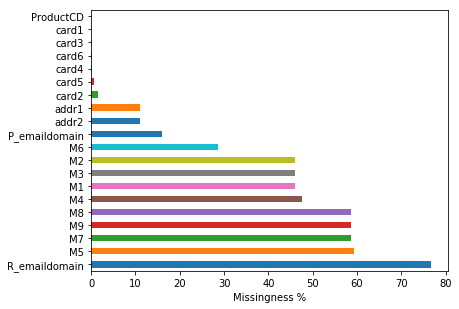

In [13]:
def rank_missingness(dat, top_n=None, figsize=None):
    """
    Rank the columns of a DataFrame by their rate of missingness. Also provide
    barchart of missingness levels.
    
    :param dat: pd.DataFrame
    :param top_n: int display the top-n columns in dat with the highest rate of missing values
    :param figsize: list or tuple of length 2, w x h of resulting plot.
    """
    missing_dat = 100 * dat.isnull().sum(axis=0) / dat.shape[0]
    missing_dat.sort_values(ascending=False
                            , inplace=True)
    
    if isinstance(top_n, int):
        top_n = min(top_n, missing_dat.shape[0])
        missing_dat = missing_dat[0:top_n]

    p = missing_dat.plot(kind = 'barh', figsize=[6.4, 4.8] if figsize else figsize)
    p.set_xlabel('Missingness %')
    
    return missing_dat


# -- plot missingness among categorical features
tr_cat_missing_dat = rank_missingness(tr_df[tr_cat_features], figsize=[10, 6])

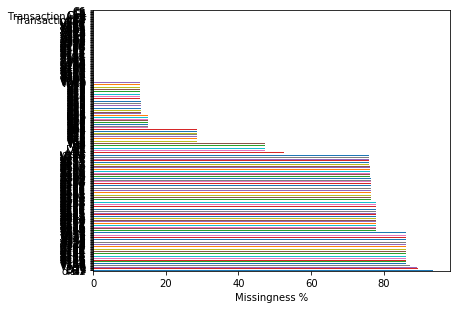

In [14]:
# -- plot missingness among numeric features
tr_num_missing_dat = rank_missingness(tr_df[tr_num_features], figsize=[10, 6])

## Categorical feature selection/engineering

Categorical features are usually a bit more of a pain when it comes to modeling than numeric features because most models (especially parametric models) require fully-numeric feature matrices ``X``. There are ways around that by using models like `catboost` that are amenable to using categorical features in their raw form, but most models are not.

Here is how I generally handle categorical features when under a time crunch:

1. Encode missing categorical feature values as a true level called "NA", and cast all categorical features to dataype `str`.
2. Use the $\chi^{2}$ test to identify which categorical features are independent from `isFraud`, in which case it would be unlikely that a feature that's independent from `isFraud` will be able to help predict `isFraud`:
$$H_{0_{j}}: \text{isFraud } {\perp\!\!\!\perp} \text{ Feature}_{j}$$
$$H_{1_{j}}: \text{isFraud and } \text{Feature}_{j} \text{ are not independent}$$
4. For "brutally categorical" features (with say, > 20 unique values), we will one-hot-encode these features, and then further, we will take the low-rank approximation (using the SVD) to the one-hot-encoded feature matrix. Learning from a one-hot-encoded matrix representing 100's of unique levels from just one categorical feature can really slow down model training.

In [15]:
def find_brutally_categorical_features(dat, brutal=20):
    """
    Find `brutally categorical features`, i.e. categorical features with > k unique levels.
    
    :param dat: pd.DataFrame consisting only of categorical features
    :param brutal: int number of unique levels found in a feature before the feature
    is declared "brutally categorical"
    :return: list of feature names with at least `brutal` unique levels
    """
    bcat_features = list()
    
    for feature in dat.columns:
        
        vcounts = dat[feature].value_counts()
        if vcounts.shape[0] >= brutal:
            print(f'{feature} is a brutally categorical feature: {vcounts.shape[0]} levels')
            bcat_features.append(feature)    
            
    return bcat_features


# -- find brutally categorical features: cat features with > 20 unique levels
tr_brutal_cat_features = find_brutally_categorical_features(tr_df[tr_cat_features])

P_emaildomain is a brutally categorical feature: 59 levels
R_emaildomain is a brutally categorical feature: 60 levels
addr1 is a brutally categorical feature: 332 levels
addr2 is a brutally categorical feature: 74 levels
card1 is a brutally categorical feature: 13553 levels
card2 is a brutally categorical feature: 500 levels
card3 is a brutally categorical feature: 114 levels
card5 is a brutally categorical feature: 119 levels


In [ ]:
def run_chi2_test(dat, y):
    """
    Run chi-square tests on a set of categorical features. One categorical feature = one test.
    Each test computes the expected number of +/- class-label entries per categorical feature level
    were the class-labels independent of the categorical feature in question.
    
    When p-value > 0.05, interpret this to mean that we reject H0 that class and feature are independent.
    
    :param dat: pd.DataFrame containing categorical features in str form (cannot contain NaNs). Shape n x p.
    :param y: 1-d np.array or pd.Series of class-labels. Shape n x 1.
    :return: 1-d np.array of p-values
    """

    # -- encode categorical features from str to integer.
    cat_enc = OrdinalEncoder()
    cat_enc.fit(dat)

    # -- run chi-square tests on integer-encoded dataset.
    chi = chi2(cat_enc.transform(dat)
               , y=y)

    # -- extract p-values.
    pvals = chi[1]

    # -- plot p-values.
    p = pd.Series(pvals
                  , index=dat.columns.tolist()).plot(kind='barh', figsize=[10, 6])
    p.axvline(x=0.05
              , c='red'
              , linewidth=0.5
              , linestyle='--')
    p.set_title('Chi-square test p-values: categorical features')
    p.set_xlabel('p-value')
    
    return pvals


tmp = tr_df[tr_cat_num_features + [target]].dropna()
pval_vec = run_chi2_test(tmp
                         , y=tmp[target])

### Brutally categorical features: dimensionality reduction.

The next cell emulates the sklearn Pipeline we're going to build for brutally-categorical features:

1. Encode string categorical levels into integers.
2. Encode the integers into a (sparse) one-hot-encoded matrix.
3. Reduce the dimensionality of the sparse OHE matrix into something more manageable via the SVD.

In [ ]:
# -- encode string categorical features to integers
ord_enc = OrdinalEncoder()
ord_enc.fit(tr_df[tr_brutal_cat_features])
ord_enc_dat = ord_enc.transform(tr_df[tr_brutal_cat_features])

# -- one-hot-encode the integer encoding
ohe_enc = OneHotEncoder()
ohe_enc.fit(ord_enc_dat)
ohe_enc_dat = ohe_enc.transform(ord_enc_dat)

# -- fit SVD using many components so that we can view the %-variance explained
svd_wide = TruncatedSVD(n_components=200)
svd_wide.fit(ohe_enc_dat)
var_expl = 100 * np.cumsum(svd_wide.singular_values_**2) / np.sum(svd_wide.singular_values_**2)

# -- plot variance explained by each principal component
dat = pd.DataFrame({'PC': range(svd_wide.n_components)
                  , 'cumulative %-variance explained': var_expl})
ax = sns.barplot(x='PC'
                 , y='cumulative %-variance explained'
                 , data=dat)
ax.get_xaxis().set_ticks([])

plt.show()

In [ ]:
# -- fit low-rank SVD based on % explained, project OHE data to low-rank approx.
# -- Use SVD instead of PCA because PCA transformer does
# -- not accept sparse input (memory killer).
svd = TruncatedSVD(n_components=40)
svd.fit(ohe_enc_dat)
ohe_svd_dat = svd.transform(ohe_enc_dat)

In [ ]:
np.random.seed(seed=666)

# -- downsample so we can visualize more quickly
dsamp_vec = np.random.choice(range(ohe_svd_dat.shape[0])
                             , size=10000
                             , replace=False)

# -- clustering does not seem handily apparent,
# -- but then again none of these brutally categorical features
# -- showed up in our chi-square test as non-independent from target variable.
dims = [0, 1]
plt.scatter(ohe_svd_dat[dsamp_vec, dims[0]]
            , y = ohe_svd_dat[dsamp_vec, dims[1]]
            , alpha=0.5
            , c=tr_df[target].iloc[dsamp_vec]
            , cmap='viridis')

plt.title('SVD projection of OHE brutally-categorical features')
plt.xlabel('PC dimension ' + str(dims[0]))
plt.ylabel('PC dimension ' + str(dims[1]))

plt.show()

## Numeric feature selection/engineering

By numeric features I mean roughly-continuously valued features. There are some easily-interpretable methods for feature selection and feature engineering. Here are some that I like to apply:

1. t-tests: does the distribution of feature $X_{j}$ actually change between the classes in the target vector $y$?
2. Variance thresholding: does feature $X_{j}$ have variance that's reasonably bounded away from 0? We don't want to add nearly-constant terms to our model, it won't add any modeling capacity.
3. Find highly correlated numeric features. These are multicolinear, and will cause issues in fitting linear/GLM models. In theory, taking one feature vs. its highly-correlated counterpart should not really matter for modeling purposes.
3. Applying LASSO feature engineering: by applying an increasing level of regularization in a penalized linear regression model (e.g. the LASSO model), we can easily visualize which features are quickly dropped under low-regularization and which features endure until the regularization penalty is simply too large.

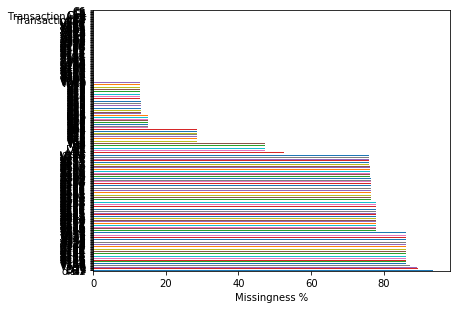

In [16]:
# -- plot missingness among numeric features.
tr_num_missing_dat = rank_missingness(tr_df[tr_num_features]
                                      , figsize=[10, 6])

In [ ]:
from scipy.stats import ttest_ind


def run_ttests(dat, y, equal_var=False):
    """
    Run t-tests over features in a pandas Data.Frame between groups defined in a 
    binary label vector, `y`.
    
    
    :param dat: pd.DataFrame containing numeric features. Shape `n x p`
    :param y: pd.Series or np.array of binary target labels in {0, 1}. Shape `n x 1`.
    :param equal_var: bool should t-test assume equal variance between the two groups in `y`?
    :return: list of column names in dat found to have significantly different means
    between the two groups
    """    
    signif_features = list()
    
    # -- get indices of positive/negative class instances
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    # -- iterate over features
    for feature in dat.columns:
        
        fvec = dat[feature].values
        
        # -- run t-test
        pval = ttest_ind(fvec[pos_idx]
                         , b=fvec[neg_idx]
                         , axis=0
                         , equal_var=equal_var).pvalue

        if pval <= 0.05:
            signif_features.append(feature)
            print(feature + ' p-value = {0:.4f}'.format(pval))
            
    return signif_features


# -- find significant features according to t-test
signif_num_features = run_ttests(tr_df[tr_num_features]
                                 , y=tr_df[target]
                                 , equal_var=False)

In [ ]:
def plot_grouped_histograms(dat, y, std=False):
    """
    Provide plotting functionality - plot grouped histograms for the features
    provided in a pd.DataFrame, grouped by class labels in the target vector, `y`.
    
    :param dat: pd.DataFrame containing numeric features. Shape `n x p`
    :param y: pd.Series or np.array of binary target labels in {0, 1}. Shape `n x 1`.
    """
    n_subplots = dat.shape[1]    
    n_row = int(np.ceil(n_subplots / 2))
    n_col = 1 if n_subplots == 1 else 2
    
    fig, ax = plt.subplots(n_row, n_col, figsize=[n_col*6, n_row*3])
    
    for i in range(n_subplots):
        fvec = dat.values[:, i]
        
        # -- get indices of positive/negative class instances
        pos_idx = np.where(y == 1)[0]
        neg_idx = np.where(y == 0)[0]
        
        # -- plot n/2 x 2 grid.
        if n_row > 1:
            plt_row = int(np.floor(i / 2))
            plt_col = 0 if i % 2 == 0 else 1
            
            x_pos = fvec[pos_idx]
            x_neg = fvec[neg_idx]
            
            # -- normalize distributions before plotting hists, if asked to do so
            if std:
                x_pos = (x_pos - np.mean(x_pos)) / np.std(x_pos)
                x_neg = (x_neg - np.mean(x_neg)) / np.std(x_neg)
            
            ax[plt_row, plt_col].hist(x_pos
                                        , bins=50
                                        , alpha=0.5
                                        , color='r'
                                        , label='1'
                                         , density=True
                                         , stacked=True)

            ax[plt_row, plt_col].hist(x_neg
                                        , bins=50
                                        , alpha=0.5
                                        , color='b'
                                        , label='0'
                                        , density=True
                                         , stacked=True)
            ax[plt_row, plt_col].set_title(dat.columns[i])
            
        # -- plot 1 x 2 grid.
        elif n_subplots == 2:
            ax[i].hist(fvec[pos_idx]
                       , bins=50
                       , alpha=0.5
                       , color='r'
                       , label='1'
                       , density=True
                       , stacked=True)

            ax[i].hist(fvec[neg_idx]
                       , bins=50
                       , alpha=0.5
                       , color='b'
                       , label='0'
                       , density=True
                       , stacked=True)
            ax[i].set_title(dat.columns[i])
        
        # -- plot single histogram.
        else:
            ax.hist(fvec[pos_idx]
                       , bins=50
                       , alpha=0.5
                       , color='r'
                       , label='1'
                       , density=True
                       , stacked=True)

            ax.hist(fvec[neg_idx]
                       , bins=50
                       , alpha=0.5
                       , color='b'
                       , label='0'
                       , density=True
                       , stacked=True)
            ax.set_title(dat.columns[i])

plot_grouped_histograms(tr_df[signif_num_features]
                        , y = tr_df[target]
                        , std=True)

In [ ]:
def identify_degenerate_features(dat, ecdf_threshold=0.95):
    """
    Identify low-variance features by the following criteria:
    1. Find a feature's modal value.
    2. If more than > ecdf_threshold% of all data samples take on that modal value,
    then consider the feature degenerate.
    
    :param dat: pd.DataFrame containing numeric features. Shape `n x p`.
    :param ecdf_threshold: float in [0, 1], represents cutoff value in terms of cumulative amount of
    time spent at the modal value. If a feature spends > ecdf_threshold% of time at the modal value,
    consider the feature a stagnant feature.
    :return: list of str, names of stagnant features.
    """
    if ecdf_threshold < 0 or ecdf_threshold > 1:
        raise ValueError('ecdf_threshold must lie within [0, 1]')
    
    degen_feature_dat = dat.apply(lambda x: x.value_counts(normalize=True
                                                           , ascending=False).max() > ecdf_threshold
                                 , axis=0)
    degen_features = degen_feature_dat[degen_feature_dat].index.tolist()
    
    
    return degen_features


# -- identify degenerate numeric/categorical features
degenerate_num_features = identify_degenerate_features(tr_df[tr_num_features])
degenerate_cat_features = identify_degenerate_features(tr_df[tr_cat_features])

# -- exclude degenerate features from greater set of numeric features
tr_num_features = [x for x in tr_num_features if x not in degenerate_num_features]

In [ ]:
# -- biclustering! See if there are important grouped-up patterns in correlation among our features.
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score


def bicluster_correlation_matrix(dat, n_clusters=10, figsize=None):
    """
    Group similar variables together by running Spectral coclustering algorithm on a dataset's correlation matrix.
    See https://bit.ly/2QgXZB2 for more details.
    
    Spectral coclustering finds groups of similar (row, column) subsets where each column can only belong to 
    a single bicluster. This is different than "checkerboard" biclustering.
    
    :param dat: pd.DataFrame containing numeric features. Shape `n x p`.
    :param n_clusters: int number of biclusters to construct
    :param figsize: 2-tuple of int, pyplot Figure size. Default [10, 6].
    :return: fitted sklearn.cluster.SpectralCoclustering model
    """

    # -- get estimate of correlation matrix using median-imputed version of data,
    # -- and then downsample to 50k datapoints for speed.
    num_df = dat.iloc[np.random.choice(range(dat.shape[0])
                                       , size=min(100000, dat.shape[0])
                                       , replace=False)]
    cor_mat = num_df.fillna(num_df.median()).corr()

    # -- run coclustering.
    coclust = SpectralCoclustering(n_clusters=n_clusters
                                   , random_state=666)
    coclust.fit(cor_mat)

    # -- re-order correlation matrix by cluster indices.
    biclust_dat = cor_mat.iloc[np.argsort(coclust.row_labels_)]
    biclust_dat = biclust_dat.iloc[:, np.argsort(coclust.column_labels_)]

    # -- display biclustering pattern.
    fig = plt.figure(figsize=figsize if figsize else [10, 10])
    ax = fig.add_subplot(111)
    ax = ax.matshow(biclust_dat
                     , cmap='cool')
    ax.set_title(f'Correlation matrix post-biclustering: {n_clusters} clusters')

    ax.set_yticks(range(biclust_dat.shape[0]))
    ax.set_yticklabels(biclust_dat.index.tolist())

    plt.show()
    
    return coclust
    

# -- run biclustering on numeric features.
clust = bicluster_correlation_matrix(tr_df[tr_num_features]
                                     , n_clusters=12
                                     , figsize=[20, 20])

In [34]:
class UncorrelatedFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom feature selector to drop highly-correlated features.
    This should technically inherit from a SelectorMixin class, as this is a an implementation
    of a feature selector not a feature transformer, but the TransformerMixin api is easier to work with.
    
    Args:
        drop_threshold: (float) absolute value of correlation coefficient, beyond which
                        one of (feature_i, feature_j) will be dropped should they be found to be highly correlated.
        dsample: (float or int) either fraction of dataset or integer number of rows to sample in order to compute
                correlation matrix.
    """
    def __init__(self, cor_threshold=0.95, dsample=50000, seed=None):
        self.cor_threshold = cor_threshold
        self.dsample = dsample
        self._is_df = False
        self._mask = None
        self._seed = seed
        
        
    def fit(self, X, y = None):
        """
        Sample data to create a correlation matrix and find features in 
        X that are highly correlated with others.
        
        Args:
            X: pd.DataFrame or 2-d numpy.array
        """
        n, p = X.shape
                
        # -- determine downsampling rate for computing correlation matrix.
        if isinstance(self.dsample, float) and self.dsample > 0 and self.dsample <= 1:
            dsample = self.dsample * n
            
        elif self.dsample > 1:
            dsample = self.dsample
            
        else:
            dsample = n
        
        # -- create downsampling index vector.
        dsample = min(dsample, n)
        
        if self._seed:
            np.random.seed(self._seed)
            
        self._dsample_vec = np.random.choice(range(n)
                                             , size=dsample
                                             , replace=False)
                        
        # -- workflow for dataframe input.
        if isinstance(X, pd.DataFrame):
            cor_mat_abs = X.iloc[self._dsample_vec].corr().abs().values
            self._is_df = True

        # -- workflow for numpy array input.
        else:
            # -- np.corrcoef by default thinkns of rows as variables... and cols as observations(?)
            take_cor = X[self._dsample_vec, :] if not issparse(X) else X[self._dsample_vec, :].todense()
            cor_mat_abs = np.abs(np.corrcoef(take_cor
                                            , rowvar=False))
            del take_cor
            
        cor_upper = np.triu(cor_mat_abs, k=1)
         
        # -- Identify multicollinear features and drop them from X.
        hi_cor_features = [j for j in range(p) if np.any(cor_upper[:, j] > self.cor_threshold)]
        self._mask = np.sort(np.array(list(set(range(p)) - set(hi_cor_features))))
        
        return self
    
        
    def transform(self, X, y = None):
        """
        Reduce X to the selected non-highly correlated features.

        Args:
            X: pd.DataFrame or 2-d numpy.array
        """
        if not isinstance(self._mask, np.ndarray):
            raise NotFittedError()
        
        if self._is_df:
            return X.iloc[:, self._mask]
        
        else:
            return X[:, self._mask]
        
        
class NonDegenerateFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Custom feature selector to drop degenerate (i.e. very low-variance) features.
    
    Args:
        ecdf_threshold: (float) proportion between 0 and 1 of values in a given feature
                        taking on a single value before the feature is witheld from feature set.
    """
    def __init__(self, ecdf_threshold=0.95):
        ecdf_threshold = 1. if not ecdf_threshold else ecdf_threshold
        
        if (ecdf_threshold < 0.) or (ecdf_threshold > 1.):
            raise ValueError('ecdf_threshold must lie within [0, 1]')
            
        self.ecdf_threshold = ecdf_threshold
        self.is_df = None
        
        
    def fit(self, X, y = None):
        """
        Identify features that take on a single value at least 100% x ecdf_threshold of the time.
        
        Args:
            X: pd.DataFrame or 2-d numpy.array
        """
        n, p = X.shape
        self._is_df = isinstance(X, pd.DataFrame)
        
        # -- workflow for pandas dataframe vs. numpy array.
        degen_features = list()
        if self._is_df:
            degen_features = X.apply(lambda z: z.value_counts(normalize=True
                                                              , ascending=False).max() >= self.ecdf_threshold
                                     , axis=0).index.tolist()
        
        else:
            sp = issparse(X)
            
            for j in range(p):
                max_occ = np.max(np.unique(X[:, j] if not sp else np.ravel(X[:, j].todense())
                                           , return_counts=True)[1] / n)
                if max_occ >= self.ecdf_threshold:
                    degen_features.append(j)
                    
        self._mask = np.sort(np.array(list(set(range(p)) - set(degen_features))))

        return self
    
    
    def transform(self, X, y = None):
        
        if not isinstance(self._mask, np.ndarray):
            raise NotFittedError()
        
        if self._is_df:
            return X.iloc[:, self._mask]
        
        else:
            return X[:, self._mask]

# Build the pipeline


### Categorical features:
1. Impute data:
    - string-categorical features: missing values -> 'NA'
    - int/float-categorical feautures: missing values -> -999
    - numeric features: nan -> median feature value
2. Binarize 
2. Impute missing categorical feature values with the string value 'NA'.
3. One-hot 


In [90]:
# -- find features with high missingness that will be converted into 
# -- missingness indicator features.
tr_cat_binarize_cols = tr_cat_missing_dat[tr_cat_missing_dat > 50].index.tolist()
tr_num_binarize_cols = tr_num_missing_dat[tr_num_missing_dat > 50].index.tolist()

# -- find high-cardinality features
tr_hi_card_cols = tr_brutal_cat_features
tr_lo_card_cols = list(set(tr_cat_features) - set(tr_hi_card_cols))

# -- separate string/numeric-valued high/lo-cardinality features.
tr_cat_num_hi_card_features = [x for x in tr_cat_num_features if x in tr_hi_card_cols]
tr_cat_str_hi_card_features = [x for x in tr_cat_str_features if x in tr_hi_card_cols]
tr_cat_num_lo_card_features = [x for x in tr_cat_num_features if x in tr_lo_card_cols]
tr_cat_str_lo_card_features = [x for x in tr_cat_str_features if x in tr_lo_card_cols]

hi_card_cat_imputer = ColumnTransformer([('impute_hi_card_cat_num', SimpleImputer(strategy='constant', fill_value=-999), tr_cat_num_hi_card_features)
                                            , ('impute_hi_card_cat_str', SimpleImputer(strategy='constant', fill_value='NA'), tr_cat_str_hi_card_features)])
hi_card_pipeline = make_pipeline(hi_card_cat_imputer
                                 , OneHotEncoder(handle_unknown='ignore')
                                 , TruncatedSVD(n_components=100))

# -- define low-cardinality categorical processing pipeline defined only on low-cardinality categorical features.
lo_card_cat_imputer = ColumnTransformer([('impute_lo_card_cat_num', SimpleImputer(strategy='constant', fill_value=-999), tr_cat_num_lo_card_features)
                                            , ('impute_lo_card_cat_str', SimpleImputer(strategy='constant', fill_value='NA'), tr_cat_str_lo_card_features)])

lo_card_pipeline = make_pipeline(lo_card_cat_imputer
                                 , OneHotEncoder(handle_unknown='ignore'))
    
# -- create separate binarizer only defined on high-missingness categorical features.
cat_binarizer = ColumnTransformer([('missing_cat_binarizer', MissingIndicator(), tr_cat_binarize_cols)])

# -- column-concatenate separate categorical feature pipelines
cat_pipeline = FeatureUnion([('hi_card', hi_card_pipeline)
                             , ('lo_card', lo_card_pipeline)
                             , ('missing_cat_binarizer', cat_binarizer)])

# -- create numeric feature processing pipeline defined only on numeric features.
num_binarizer = ColumnTransformer([('missing_num_binarizer', MissingIndicator(), tr_num_binarize_cols)])
num_pipeline = make_pipeline(ColumnTransformer([('impute_num', SimpleImputer(strategy='median'), tr_num_features)])
                             , StandardScaler())

benchmark_feature_pipeline = deepcopy(num_pipeline)

# -- column-concatenate separate missingness-binarized variables.
num_pipeline = FeatureUnion([('num_pipeline', num_pipeline)
                             , ('missing_num_binarizer', num_binarizer)])


feature_pipeline = Pipeline(steps=[('preprocess', FeatureUnion([('categorical', cat_pipeline)
                                                                , ('numeric', num_pipeline)]))
                                   , ('decorrelate', UncorrelatedFeatureSelector())
                                   , ('nondegenerate', NonDegenerateFeatureSelector(ecdf_threshold=0.95))])

# Training, test split

Since we have nearly 600,000 training examples, an 80%/20% training/test split will still provide us close to half a million training examples and close to 100,000 test examples.

In [82]:
x_df_train, x_df_test, y_train, y_test = train_test_split(tr_df[tr_num_features + tr_cat_features]
                                                          , tr_df[target].values
                                                          , test_size=0.2
                                                          , random_state=666)


def find_pipeline_params(p, pattern):
    for k in p.get_params().keys():
        if re.search(pattern, string=k):
            msg = f'parameter matching pattern "{pattern}": {k}'
            print(msg)

## Define a benchmark model

We should define an easily-understood benchmark model whose performance metrics will serve as a lower-bound against more complex models' performance. If we can't beat the benchmark model's performance with a really large, black-box model, then we should settle for the benchmark's performance.

The benchmark model we'll use looks like this:
1. Using *only* continuous features, first impute and standardize the inputs.
2. Select the k-best features according to F-test scores (measures of between-class variance vs. within-class variance).
3. Random nonlinear feature generation based on these top *k* features through Random Kitchen Sinks method approximating a radial basis function kernel.
4. Penalized SVM model with linear kernel.

In [39]:
# -- benchmark model: Kernel approximation via K-best feature selection + RKS + regularized linear SVM
x_bench_df_train, x_bench_df_test, y_bench_train, y_bench_test = train_test_split(tr_df[tr_num_features]
                                                                          , tr_df[target].values
                                                                          , test_size=0.2
                                                                          , random_state=666)
# -- fit benchmark preprocessing pipeline
benchmark_feature_pipeline = make_pipeline(benchmark_feature_pipeline
                                           , UncorrelatedFeatureSelector()
                                           , NonDegenerateFeatureSelector(ecdf_threshold=0.95))
x_bench_train = benchmark_feature_pipeline.fit_transform(x_bench_df_train)

# -- fit benchmark model pipeline
benchmark_model_pipeline = Pipeline(steps=[('lasso', LogisticRegression(penalty='l1'
                                                                        , solver='liblinear'
                                                                        , class_weight = {0: 1, 1: 4}))
                                          ])

# -- run benchmark model grid search, tallying F1 and ROC AUC along the way.
# -- Since classes are so unbalanced, accuracy is not a really helpful scoring metric.
benchmark_gcv = GridSearchCV(benchmark_model_pipeline
                             , param_grid=dict(lasso__C=[0.1, 1, 10, 100])
                             , cv=3
                             , n_jobs=2
                             , scoring=['f1', 'roc_auc', 'recall', 'precision', 'accuracy']
                             , refit = 'f1'
                             , verbose=10)

# -- run grid search job. Ensure that targets are integers (by rounding).
benchmark_gcv.fit(x_bench_train
                  , y=y_bench_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:  2.8min remaining:  1.4min
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  4.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lasso',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 1,
                                                                         1: 4},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l1',
                                            

In [44]:
benchmark_gcv.best_params_

{'lasso__C': 1}

In [45]:
# -- RKS: max precision about ~0.51, f1 score in the basement (very low recall)
# -- Without RKS + class weights: f1 score is ~ 0.337, precision .47 and recall .26
benchmark_gcv.cv_results_

{'mean_fit_time': array([78.22804697, 84.83962631]),
 'std_fit_time': array([11.95963038,  2.96809056]),
 'mean_score_time': array([0.74578094, 0.75446447]),
 'std_score_time': array([0.0652471 , 0.16592835]),
 'param_lasso__C': masked_array(data=[0.1, 1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lasso__C': 0.1}, {'lasso__C': 1}],
 'split0_test_f1': array([0.33877882, 0.3388382 ]),
 'split1_test_f1': array([0.33168083, 0.33227214]),
 'split2_test_f1': array([0.33399141, 0.33600186]),
 'mean_test_f1': array([0.33481702, 0.33570407]),
 'std_test_f1': array([0.00295596, 0.00268884]),
 'rank_test_f1': array([2, 1], dtype=int32),
 'split0_test_roc_auc': array([0.81680815, 0.81674815]),
 'split1_test_roc_auc': array([0.81753634, 0.81748836]),
 'split2_test_roc_auc': array([0.82158584, 0.82160272]),
 'mean_test_roc_auc': array([0.81864344, 0.81861308]),
 'std_test_roc_auc': array([0.00210172, 0.00213549]),
 'rank_test_roc_auc': array

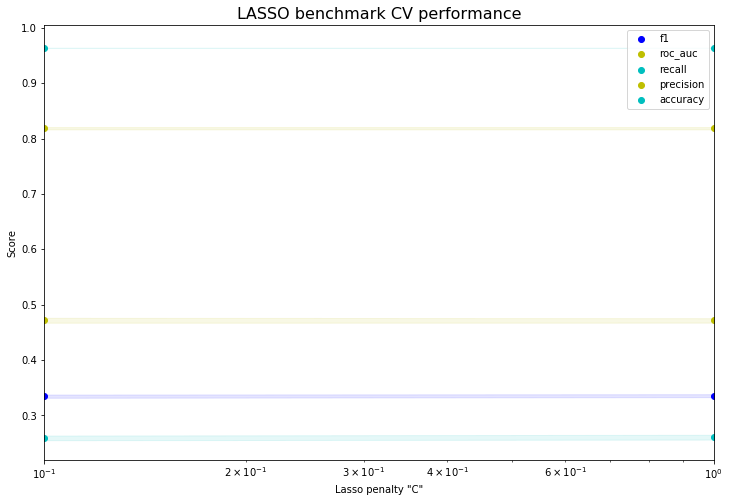

In [46]:
plt.figure(figsize = [12, 8])
plt.title('LASSO benchmark CV performance',
          fontsize = 16)

plt.xlabel('Lasso penalty "C"')
plt.ylabel('Score')
range_C = benchmark_gcv.param_grid['lasso__C']

ax = plt.gca()
ax.set_xlim(min(range_C), max(range_C))
# ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
x_axis = np.array(range_C)

metrics = list(benchmark_gcv.scorer_.keys())
colors = np.random.choice(['b', 'g', 'r', 'c', 'm', 'y', 'k']
                          , size = len(metrics)
                          , replace = True)

for metric, color in zip(metrics, colors):
    sample_score_mean = benchmark_gcv.cv_results_['mean_test_{0}'.format(metric)]
    sample_score_std = benchmark_gcv.cv_results_['std_test_{0}'.format(metric)]
    ax.fill_between(x_axis
                    , y1 = sample_score_mean - sample_score_std
                    , y2 = sample_score_mean + sample_score_std
                    , alpha=0.1
                    , color=color)
    ax.scatter(x_axis
            , sample_score_mean
            , color=color
            , alpha=1
            , label=metric)

plt.xscale('log',basex=10) 
plt.legend(loc = 'best')
plt.grid(False)
plt.show()

In [47]:
x_test = benchmark_feature_pipeline.transform(x_bench_df_test)
test_preds = benchmark_gcv.best_estimator_.predict(x_test)
test_pred_probs = benchmark_gcv.best_estimator_.predict_proba(x_test)[:, 1]
# threshold = np.max(benchmark_gcv.cv_results_['mean_test_f1']) / 2
threshold = 0.5
test_preds = (test_pred_probs > threshold).astype(int)

In [48]:
from sklearn.metrics import confusion_matrix
# disp = plot_confusion_matrix(benchmark_gcv, x_test, y_test,
#                                  display_labels=[0, 1],
#                                  cmap=plt.cm.Blues,
#                                  normalize='all')
confusion_matrix(y_test
                , y_pred=test_preds
                , normalize='all')

array([[0.95536289, 0.01013479],
       [0.02534968, 0.00915264]])

In [50]:
test_tp = np.intersect1d(np.where(test_preds == 1), np.where(y_test == 1))
test_precision = len(test_tp) / np.sum(test_preds)
test_recall = len(test_tp) / np.sum(y_test)
print(test_precision, test_recall)

0.4745390693590869 0.2652760736196319


In [94]:
# x_train = feature_pipeline.fit_transform(x_df_train)
p_train = x_train.shape[1]

# -- fit benchmark model pipeline
model = ExtraTreesClassifier(class_weight='balanced')
#                             , bootstrap=True)

# -- run benchmark model grid search, tallying F1 and ROC AUC along the way.
# -- Since classes are so unbalanced, accuracy is not a really helpful scoring metric.
gcv = GridSearchCV(model
                             , param_grid=dict(max_features=[np.int(np.sqrt(p_train))
                                                            , p_train]
                                              , n_estimators=[20, 100, 200])
                             , cv=3
                             , n_jobs=2
                             , scoring=['f1', 'roc_auc', 'recall', 'precision', 'accuracy']
                             , refit = 'f1'
                             , verbose=10)

# -- run grid search job. Ensure that targets are integers (by rounding).
gcv.fit(x_train[0:10000, :]
        , y=y_train[0:10000])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   15.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   39.1s
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight='balanced',
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose

In [95]:
x_test = feature_pipeline.transform(x_df_test)
test_preds = gcv.best_estimator_.predict(x_test)
test_pred_probs = gcv.best_estimator_.predict_proba(x_test)[:, 1]
threshold = 0.5
test_preds = (test_pred_probs > threshold).astype(int)

In [96]:
test_tp = np.intersect1d(np.where(test_preds == 1), np.where(y_test == 1))
test_precision = len(test_tp) / np.sum(test_preds)
test_recall = len(test_tp) / np.sum(y_test)
print(test_precision, test_recall)

0.7180232558139535 0.18184049079754602


In [113]:
gcv.cv_results_.get('params')

[{'max_features': 7, 'n_estimators': 20},
 {'max_features': 7, 'n_estimators': 100},
 {'max_features': 7, 'n_estimators': 200},
 {'max_features': 15, 'n_estimators': 20},
 {'max_features': 15, 'n_estimators': 100},
 {'max_features': 15, 'n_estimators': 200},
 {'max_features': 249, 'n_estimators': 20},
 {'max_features': 249, 'n_estimators': 100},
 {'max_features': 249, 'n_estimators': 200}]

In [136]:
cv_df = pd.DataFrame(dict(mean_f1 = gcv.cv_results_.get('mean_test_f1')
                          , mean_precision = gcv.cv_results_.get('mean_test_precision')
                          , mean_recall = gcv.cv_results_.get('mean_test_recall')
                          , mean_accuracy = gcv.cv_results_.get('mean_test_accuracy')))
cv_df['params'] = [str(gcv.cv_results_.get('params')[i]) for i in range(cv_df.shape[0])]

In [179]:
gcv.scoring

['f1', 'roc_auc', 'recall', 'precision', 'accuracy']

In [137]:
cv_df

,mean_accuracy,mean_f1,mean_precision,mean_recall,params
0,0.9685,0.200113,0.868687,0.115142,"{'max_features': 7, 'n_estimators': 20}"
1,0.9678,0.168878,0.833333,0.095027,"{'max_features': 7, 'n_estimators': 100}"
2,0.9683,0.200477,0.815311,0.115192,"{'max_features': 7, 'n_estimators': 200}"
3,0.9678,0.188379,0.756667,0.109395,"{'max_features': 15, 'n_estimators': 20}"
4,0.9678,0.192954,0.747186,0.112269,"{'max_features': 15, 'n_estimators': 100}"
5,0.9685,0.213050,0.802020,0.123813,"{'max_features': 15, 'n_estimators': 200}"
6,0.9673,0.213894,0.630756,0.129535,"{'max_features': 249, 'n_estimators': 20}"
7,0.9677,0.220152,0.667360,0.132434,"{'max_features': 249, 'n_estimators': 100}"
8,0.9679,0.217375,0.698889,0.129560,"{'max_features': 249, 'n_estimators': 200}"


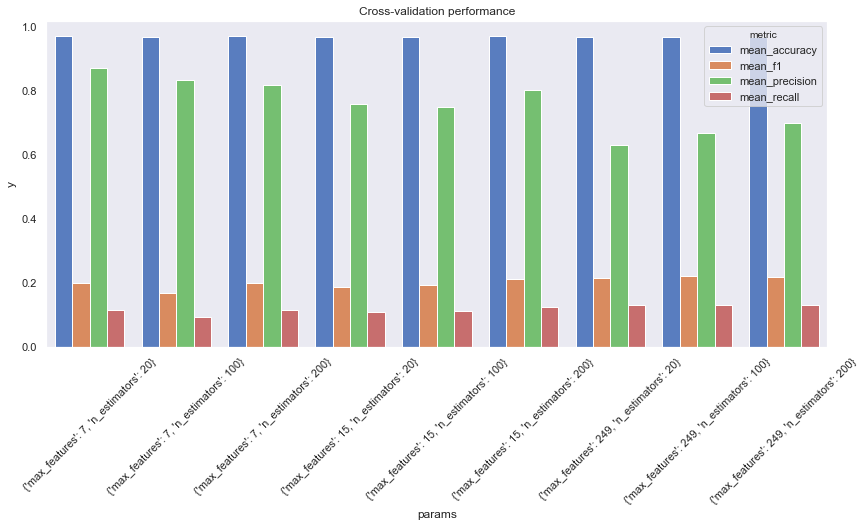

In [175]:
plot_df = pd.melt(cv_df, id_vars=['params'], var_name = 'metric', value_name = 'y')


fig, ax = plt.subplots(figsize=[14, 6])
sns.catplot(x="params", y="y", hue="metric", data=plot_df
            ,height=6, kind="bar", palette="muted", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Cross-validation performance')
plt.close(2)

In [185]:
?plot_precision_recall_curve

Text(0.5,1,'Precision-recall curve')

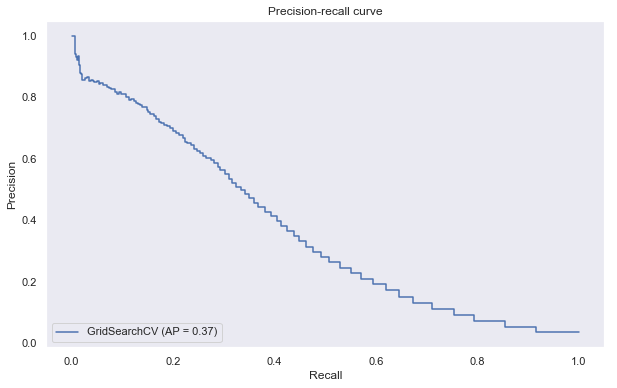

In [167]:
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(figsize=[10, 6])
plot_precision_recall_curve(gcv, x_test, y_test, ax=ax)
ax.set_title('Precision-recall curve')

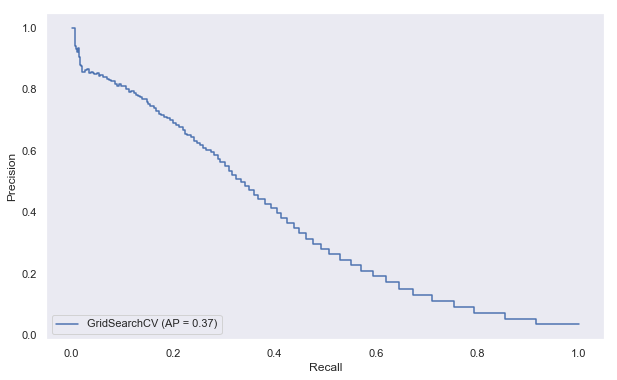

In [152]:
ax.figure.savefig('')

## Extraneous EDA tasks

- Has the rate of fraud changed over time?
- Is there autocorrelation in the fraud rate?
- Does correlation matrix change by class? (df.groupby([target]).corr())
- LASSO path plot: which features last until the highest amounts of weight penalization?
- Fit a benchmark model. Plot decision boundary along 1st, 2nd PC dimension. Do we seem to have a linearly-separable decision boundary?

In [ ]:
# -- are positive test cases more likely to have happened at certain time periods?
plt.plot(tr_df['TransactionDT'], np.cumsum(tr_df[target]))
plt.title(f'Cumulative {target} occurrences over time')

plt.show()

In [ ]:
def conditional_dist(dat, y, x, nbins=100):
    """
    Compute the (approximate) conditional distribution of a target variable
    given a specified feature (a covariate), i.e. the distribution of Y|X_j
    
    1. Bin up the values of the feature using numpy.histogram.
    2. Per bin, find the average of the target variable over all data samples in the bin.
    
    :param dat: pd.DataFrame
    :param y: str name of target variable, i.e. Y
    :param x: str name of a covariate in dat, i.e. X_j
    :param nbins: int number of bins to use when computing the histogram of 
    :return: pd.DataFrame with two columns called `feature` and `y`. Shape `nbins` x 2.
    """
    if nbins > dat.shape[0]: 
        raise ValueError('Number of bins cannot be > number of rows in dat.')
        
    # -- check that y is a valid column in dat
    if not isinstance(y, str) or y not in dat.columns:
        raise ValueError('y must be a string name of a column found in dat.')
    
    # -- check that x is a valid column in dat
    if not isinstance(x, str) or x not in dat.columns:
        raise ValueError('x must be a string name of a column found in dat.')

    # -- bin up x (avoid computing partial dependence for each unique value of x)
    hist = np.histogram(dat[x].values
                        , bins=nbins)
    bin_counts, bin_edges = hist[0], hist[1]
    
    # -- get center of histogram bins. This is where we'll compute PD.
    edge_centers, y_avg = list(), list()
    for i in range(nbins):
        edge_centers.append((bin_edges[i] + bin_edges[i + 1]) / 2)
        
    for i in range(nbins):
        # -- find average target value when feature is in given bin.
        y_avg.append(dat[(dat[x] >= bin_edges[i]) & (dat[x] < bin_edges[i + 1])][target].mean())
        
    # -- store conditional dist in a pandas DataFrame
    cond_df = pd.DataFrame([edge_centers, y_avg]).T
    cond_df.columns = [x, y]
    
    return cond_df

In [ ]:
# -- plot exponentially weighted moving average of target over time.
fraud_over_time_df = conditional_dist(tr_df
                                      , y=target
                                      , x='TransactionDT'
                                      , nbins=250)
fraud_over_time_df[target] = fraud_over_time_df[target].ewm(com=0.4).mean()

fig, ax = plt.subplots(figsize=[10, 6])
sns.lineplot(x='TransactionDT'
             , y=target
             , data=fraud_over_time_df
             , ax=ax)
ax.set_title('EWMA of fraud rate over time')

plt.show()

In [ ]:
# -- we've found autocorrelation in terms of the fraud rate over time
# -- (i.e. if there was a lot of fraud last month, there's likely to be a lot of
# -- fraud next month).
fig, ax = plt.subplots(figsize=[10, 6])
pd.plotting.autocorrelation_plot(fraud_over_time_df[target]
                                , ax=ax)
ax.set_title(f'{target} autocorrelation')

In [ ]:
# -- plot distribution of target given some other feature
fraud_given_amt = conditional_dist(tr_df, y=target, x='TransactionAmt', nbins=100).dropna()
fig, ax = plt.subplots(figsize=[10, 6])
sns.lineplot(x='TransactionAmt'
             , y=target
             , data=fraud_given_amt
             , ax=ax)
ax.set_title(f'{target} given TransactionAmt')

plt.show()

In [187]:
print('hello')
5 + 5

hello


10